In [13]:
import numpy as np
import csv
import tensorflow as tf

tf.python.control_flow_ops = tf

# 1. Parameters
data_create_or_load = 0  # 0: Create new Imageset and save, 1: Load previous Imageset
shift = 0.25  # Additional value to angle from left and right camera
shape = (100, 200)  # Size of resized image
validate_portion = 0.01 
epoch = 11
learning_rate = 0.001 
batch_size = 256

# 2. Model
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam
from keras.regularizers import l2

def model():
    model = Sequential()
    elu = ELU(alpha=1.0)    
    model.add(Convolution2D(24, 5, 5,input_shape=(66, 200, 3),subsample=(2, 2),name='C1'))
    model.add(elu)
    model.add(Dropout(0.5))
    model.add(Convolution2D(36, 5, 5,subsample=(2, 2), name='C2'))
    model.add(elu)
    model.add(Dropout(0.5))
    model.add(Convolution2D(48, 5, 5,subsample=(2, 2),name='C3'))
    model.add(elu)
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 3, 3,name='C4'))
    model.add(elu)
    model.add(Convolution2D(64, 3, 3,W_regularizer=l2(0.01),name='C5'))
    model.add(elu)
    model.add(Flatten())
    model.add(Dense(100,name='L1'))
    model.add(elu)
    model.add(Dense(50,name='L2'))    
    model.add(elu)
    model.add(Dense(10,name='L3'))
    model.add(Dense(1,name='L4'))
    return model

# 3. Functions
from scipy.misc import imread
import scipy.misc as sp
import cv2

# 3-1. Method for augment input images and combine with its flipped images
def flip_merge(data):
	length = len(data['imgc'])
	X_train = []
	y_train = []
	count = 0 # number of missed images in csv list
	aug_left_count=0 # number of augmented images
	aug_right_count=0
	rows = 66 #parameter for image translation in cv2.warpAffine
	cols = 200 #parameter for image translation
	m_right = np.float32([[1,0,10],[0,1,0]]) #Array for image translation -> right 10px
	m_left = np.float32([[1,0,-10],[0,1,0]]) #Array for image translation -> left 10px
	m_right2 = np.float32([[1,0,30],[0,1,0]]) #Array for image translation -> right 30px
	m_left2 = np.float32([[1,0,-30],[0,1,0]]) #Array for image translation -> left 30px
	for i in range(3):
		if data[0][i] == 'center': 
			for i, loc in zip(range(length), data['imgc']):
				if(i == 0):
					continue
				else:
					try:
						image = sp.imresize(imread(loc), size=shape)
						image = image[30:96, :]
						X_train.append(image)
						y_train.append(data['angle'][i])
						if data['angle'][i] >0.3:							
							temp = cv2.warpAffine(image,m_right2,(cols,rows))
							X_train.append(temp)
							y_train.append(data['angle'][i]+0.35)
							aug_right_count+=1
						elif data['angle'][i] >0.1:							
							temp = cv2.warpAffine(image,m_right,(cols,rows))
							X_train.append(temp)
							y_train.append(data['angle'][i]+0.15)
							aug_right_count+=1
						elif data['angle'][i] <-0.3:							
							temp = cv2.warpAffine(image,m_left2,(cols,rows))
							X_train.append(temp)
							y_train.append(data['angle'][i]-0.35)
							aug_left_count+=1
						elif data['angle'][i] <-0.1:							
							temp = cv2.warpAffine(image,m_left,(cols,rows))
							X_train.append(temp)
							y_train.append(data['angle'][i]-0.15)
							aug_left_count+=1
						print("Center camera resizing", i, "/", length - 1," (+ left Augmented: ",aug_left_count,", right Augmented: ",aug_right_count)
					except OSError:
						count += 1
						pass
		elif data[0][i] == 'left':
			for i, loc in zip(range(length), data['imgl']):
				if(i == 0):
					continue
				elif(len(loc) == 0):
					break
				else:
					try:
						image = sp.imresize(imread(loc), size=shape)
						X_train.append(image[30:96, :])
						y_train.append(data['angle'][i] + shift)
						print("Left camera resizing", i, "/", length - 1," (+ left Augmented: ",aug_left_count,", right Augmented: ",aug_right_count)
					except OSError:
						count += 1
						pass
		elif data[0][i] == 'right':
			for i, loc in zip(range(length), data['imgr']):
				if(i == 0):
					continue
				elif(len(loc) == 0):
					break
				else:
					try:
						image = sp.imresize(imread(loc), size=shape)
						X_train.append(image[30:96, :])
						y_train.append(data['angle'][i] - shift)
						print("Right camera resizing", i, "/", length - 1," (+ left Augmented: ",aug_left_count,", right Augmented: ",aug_right_count)
					except OSError:
						count += 1
						pass
	print(count, "files don't exist. Total number of imagaes is ", len(X_train) * 2)
	print("Fliping..")
	y_train = np.array(y_train).astype(np.float32)	
	a = []
	for i in range(len(X_train)):
		a.append(np.fliplr(X_train[i]))
	X_train = np.array(X_train)
	X_train = np.vstack((X_train, a))
	y_train = np.concatenate((y_train, -y_train))	
	print("X_train shape: ", X_train.shape)
	print("y_train shape: ", y_train.shape)
	return X_train, y_train

# 3-2. Method for save and input preprocessed images
import h5py
def save():	
	data = np.genfromtxt('./data/driving_log.csv',dtype=[('imgc','U110'),('imgl','U110'),('imgr','U110'),('angle','f8')],delimiter=",",usecols=(0,1,2,3))	
	X_train, y_train = flip_merge(data)
	try:
		with h5py.File('X_train.h5', 'w') as hf:
			hf.create_dataset("X_train",  data=X_train)
	except:
		print("X_Train Cannot be Save")
		pass	
	np.save("y_train", y_train)
	return X_train, y_train	

def load():	
	with h5py.File('X_train.h5', 'r') as hf:
		X_train = hf['X_train'][:]


	y_train = np.load("y_train.npy")
	return X_train, y_train

# 3-3. Method for generating images for train
def generator(X_train, y_train, batch_size):
	batch_train = np.zeros((batch_size, 66, 200, 3))
	batch_angle = np.zeros(batch_size)
	while True:
		for i in range(batch_size):
			batch_train[i] = X_train[i]
			batch_angle[i] = y_train[i]
			#batch_train[i] = batch_train[i]/255.-.5  # Nomalization
		yield batch_train, batch_angle

# 4. Imageset initialize (Create or Load)
X_train = []
y_train = []
if(data_create_or_load == 0):
	X_train, y_train = save()
else:
	X_train, y_train = load()

Center camera resizing 1 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 2 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 3 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 4 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 5 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 6 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 7 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 8 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 9 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 10 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 11 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 12 / 8036  (+ left Augmented:  0 , right Augmented:  0
Center camera resizing 13 / 8036  (+ left Augmented:  0 , right Augmented

In [ ]:
# Complie
model = model()
model.compile(Adam(lr=learning_rate), loss='mse', metrics=['accuracy'])


# Train
model.fit_generator(generator(X_train, y_train, 128),
	samples_per_epoch=len(X_train),
	nb_epoch=epoch,
	validation_data=generator(X_train, y_train, 128),
	nb_val_samples=len(X_validate))

# Save Model
from keras.models import load_model

model.save('model.h5')
print("Saved model to disk")
# print(model.summary())

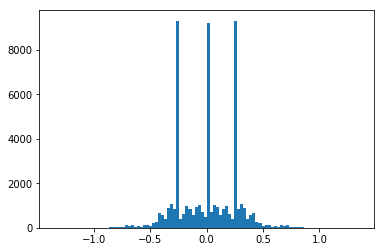

In [14]:
import numpy as np
import matplotlib.pyplot as plt
y_train = np.load("y_train.npy")
plt.hist(y_train,100)
plt.show()

In [92]:
x = np.array([[1,2,3],[13,10,43]])
print((x - np.mean(x))/np.std(x))

x = np.array([1,2,3])
print((x - np.mean(x))/np.std(x))

[[-0.75667378 -0.68788525 -0.61909673]
 [ 0.06878853 -0.13757705  2.13244428]]
[-1.22474487  0.          1.22474487]


In [80]:
import matplotlib.pyplot as plt
i=1501
image = X_train[i]
print(y_train[i])
plt.imshow(image)
plt.show()

IndexError: list index out of range

In [33]:
data[data['angle'][i]] 

NameError: name 'data' is not defined

0.0
200


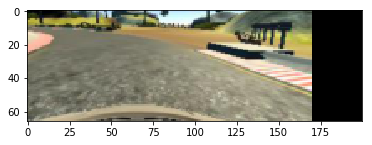

In [10]:
import cv2

i=2
img = X_train[i]
print(y_train[i])
rows = img.shape[0]
cols = img.shape[1]
print(img.shape[1])
M = np.float32([[1,0,-30],[0,1,0]])
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst)
plt.show()

0.307445


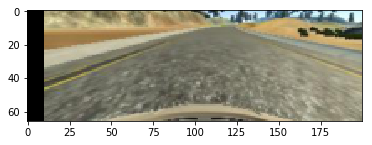

In [34]:

i=491

image = X_train[i]
print(y_train[i])
plt.imshow(image)
plt.show()

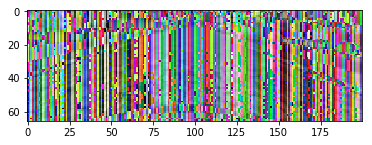

In [96]:
def generator(X_train, y_train, batch_size):
    batch_train = np.zeros((batch_size, 66, 200, 3))
    batch_angle = np.zeros(batch_size)
    while True:
        for i in range(batch_size):
            batch_train[i] = X_train[i]
            batch_angle[i] = y_train[i]
            batch_train[i]-= np.mean(X_train[i].astype(np.float32), axis=0)
            batch_train[i]/= np.std(batch_train[i], axis=0)
        return batch_train, batch_angle
#print(X_train[500])
a = X_train[500].astype(np.float32)
a-= np.mean(X_train[8000],axis=0)
#a/= np.std(a)

#print(a)


plt.imshow(a)
plt.show()
    

[[[ 0.78431373  0.77254902  0.60784314]
  [ 0.70196078  0.69019608  0.5254902 ]
  [ 0.67843137  0.67058824  0.50980392]
  ..., 
  [ 0.79215686  0.96470588  0.97254902]
  [ 0.77647059  0.95686275  0.96862745]
  [ 0.79215686  0.97254902  0.98039216]]

 [[ 0.94901961  0.94509804  0.77254902]
  [ 0.88627451  0.88235294  0.70980392]
  [ 0.84705882  0.84313725  0.67058824]
  ..., 
  [ 0.81176471  0.96078431  0.98823529]
  [ 0.80784314  0.96470588  0.98823529]
  [ 0.7254902   0.89019608  0.9372549 ]]

 [[ 0.98431373  0.98039216  0.80784314]
  [ 0.98823529  0.98823529  0.81176471]
  [ 0.96862745  0.97254902  0.79215686]
  ..., 
  [ 0.83137255  0.96470588  0.99215686]
  [ 0.74117647  0.87843137  0.90980392]
  [ 0.3254902   0.46666667  0.5372549 ]]

 ..., 
 [[ 0.38431373  0.38431373  0.3372549 ]
  [ 0.41176471  0.41176471  0.36470588]
  [ 0.41176471  0.41176471  0.36470588]
  ..., 
  [ 0.59215686  0.58431373  0.50196078]
  [ 0.57647059  0.56862745  0.48627451]
  [ 0.56862745  0.56078431  0.47843

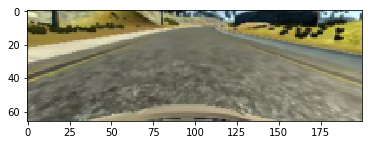

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [52]:
b = X_train[3800]/255
print(b)
plt.imshow(b)
plt.show(b)